# Movie Genre Analysis: Popularity & Quality Over Time

**Question:**  
How have the popularity (median votes) and quality (median rating) of major movie genres changed since 1995?

**Why this is important:**  
- Shows which genres are popular and well-rated over time.  
- Helps us understand trends in movies.

In [9]:
import os
import pandas as pd
import numpy as np
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb

sns.set(style="whitegrid")

In [10]:
path = kagglehub.dataset_download("vivekananda99/imdb-dataset")
print("Dataset downloaded to:", path)

Dataset downloaded to: /kaggle/input/imdb-dataset


In [11]:
for root, dirs, files in os.walk(path):
    level = root.replace(path, "").count(os.sep)
    indent = " " * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    sub_indent = " " * 4 * (level + 1)
    for f in files:
        print(f"{sub_indent}{f}")

imdb-dataset/
    title.basics.tsv
    title.episode.tsv
    title.principals.tsv
    title.ratings.tsv
    name.basics.tsv
    title.akas.tsv
    title.crew.tsv


In [12]:
import duckdb

## Filter Movies

- Only movies (`titleType = 'movie'`)  
- Released from 1995 onwards  
- Must have genre info

In [13]:
file_path = "/kaggle/input/imdb-dataset/title.basics.tsv"

# Connect to DuckDB
con = duckdb.connect(database=':memory:')

# Load title.basics and filter movies post-1995
con.execute(f"""
    CREATE TABLE movies_filtered AS
    SELECT *
    FROM read_csv_auto('{file_path}', delim='\t', nullstr='\\N')
    WHERE titleType = 'movie'
      AND startYear IS NOT NULL
      AND CAST(startYear AS INTEGER) >= 1995
      AND genres IS NOT NULL
      AND genres != ''
""")

# Check how many movies we have after filtering
filtered_count = con.execute("SELECT COUNT(*) FROM movies_filtered").fetchone()[0]
print("Filtered movies (post-1995):", filtered_count)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Filtered movies (post-1995): 366304


In [14]:
# Expand genres so that each row has only one genre
con.execute("""
    CREATE TABLE movies_expanded AS
    SELECT 
        tconst,
        CAST(startYear AS INTEGER) AS startYear,
        TRIM(genre) AS genre
    FROM movies_filtered
    LEFT JOIN UNNEST(string_split(genres, ',')) AS g(genre)
    ON TRUE
""")

# Preview expanded table
con.execute("SELECT * FROM movies_expanded LIMIT 5").fetchdf()

,tconst,startYear,genre
0,tt7222296,2017,Action
1,tt7222296,2017,Comedy
2,tt7222296,2017,Romance
3,tt7197362,1995,Action
4,tt7197362,1995,Comedy


In [15]:
# Count movies per genre
genre_counts = con.execute("""
    SELECT genre, COUNT(*) AS cnt
    FROM movies_expanded
    GROUP BY genre
""").fetchdf()

# Decide sample size per genre for ~100k total
total_sample_size = 100_000
genre_counts['sample_size'] = (genre_counts['cnt'] / genre_counts['cnt'].sum() * total_sample_size).astype(int)

print(genre_counts.sort_values('sample_size', ascending=False))

          genre     cnt  sample_size
14        Drama  133957        23813
22  Documentary  116498        20709
0        Comedy   65223        11594
1      Thriller   29212         5192
13       Action   28867         5131
2        Horror   26719         4749
20      Romance   26457         4703
18        Crime   19426         3453
9     Adventure   14213         2526
17    Biography   13796         2452
15       Family   12043         2140
3       Mystery   11914         2117
8         Music   10626         1888
10      History   10461         1859
16      Fantasy    9385         1668
5        Sci-Fi    8033         1428
4     Animation    7469         1327
7         Sport    6059         1077
6       Musical    3797          674
19          War    3597          639
26        Adult    1719          305
23         News    1388          246
25      Western     942          167
24   Reality-TV     513           91
11    Talk-Show     189           33
21    Game-Show      25            4
1

In [16]:
# Build queries for stratified sampling
queries = []
for _, row in genre_counts.iterrows():
    g = row['genre']
    n = row['sample_size']
    queries.append(f"""
        SELECT * FROM (
            SELECT *, ROW_NUMBER() OVER (PARTITION BY genre ORDER BY RANDOM()) AS rn
            FROM movies_expanded
            WHERE genre = '{g}'
        ) sub
        WHERE rn <= {n}
    """)

final_query = " UNION ALL ".join(queries)

# Execute and fetch sample into pandas
df_sampled = con.execute(final_query).fetchdf()
print("Stratified sample shape:", df_sampled.shape)
print(df_sampled['genre'].value_counts())

Stratified sample shape: (99985, 4)
genre
Drama          23813
Documentary    20709
Comedy         11594
Thriller        5192
Action          5131
Horror          4749
Romance         4703
Crime           3453
Adventure       2526
Biography       2452
Family          2140
Mystery         2117
Music           1888
History         1859
Fantasy         1668
Sci-Fi          1428
Animation       1327
Sport           1077
Musical          674
War              639
Adult            305
News             246
Western          167
Reality-TV        91
Talk-Show         33
Game-Show          4
Name: count, dtype: int64


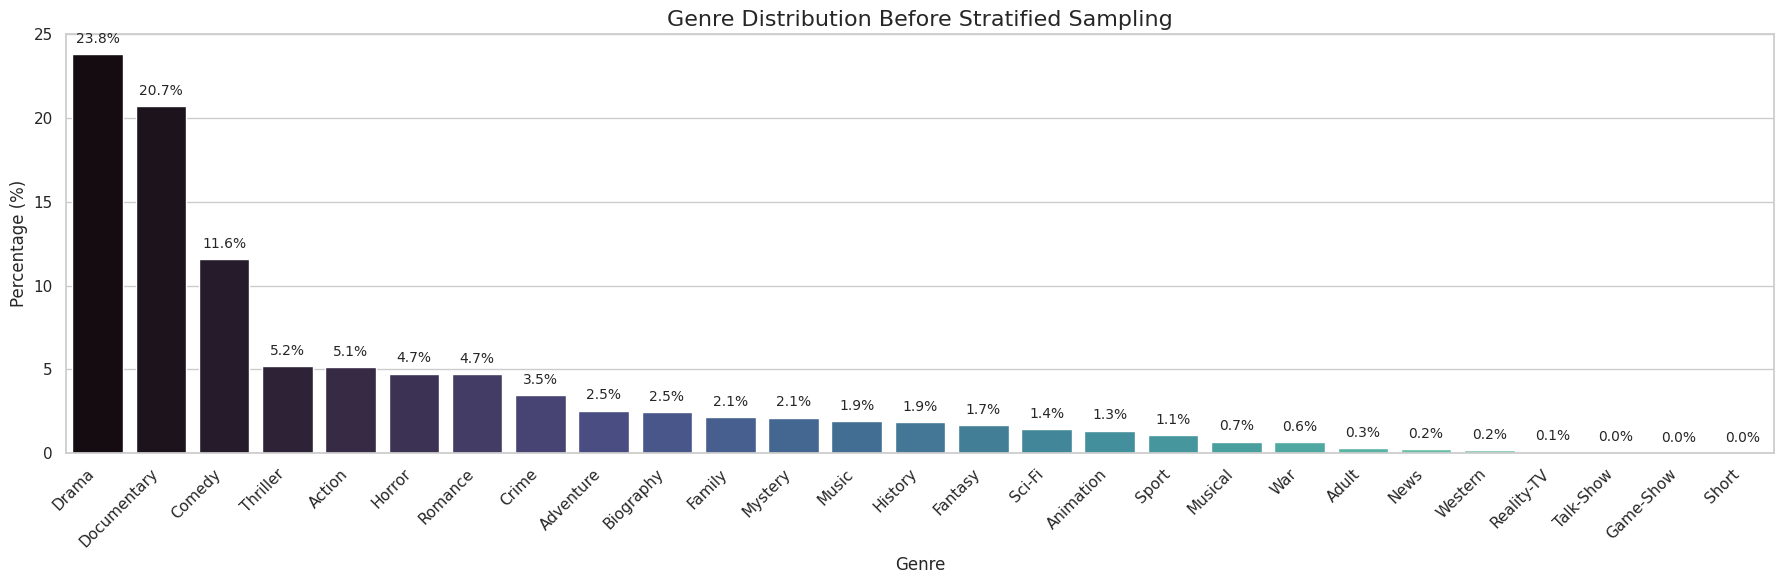

In [19]:
# Compute genre counts in original filtered dataset
genre_counts_before = con.execute("""
    SELECT genre, COUNT(*) AS cnt
    FROM movies_expanded
    GROUP BY genre
""").fetchdf()

# Compute percentage
genre_counts_before['percentage'] = genre_counts_before['cnt'] / genre_counts_before['cnt'].sum() * 100
genre_counts_before = genre_counts_before.sort_values('percentage', ascending=False)

# Plot 
plt.figure(figsize=(18,6))
sns.barplot(x='genre', y='percentage', data=genre_counts_before, palette='mako')
plt.title('Genre Distribution Before Stratified Sampling', fontsize=16)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')

for idx, row in enumerate(genre_counts_before.itertuples()):
    plt.text(idx, row.percentage + 0.5, f"{row.percentage:.1f}%", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

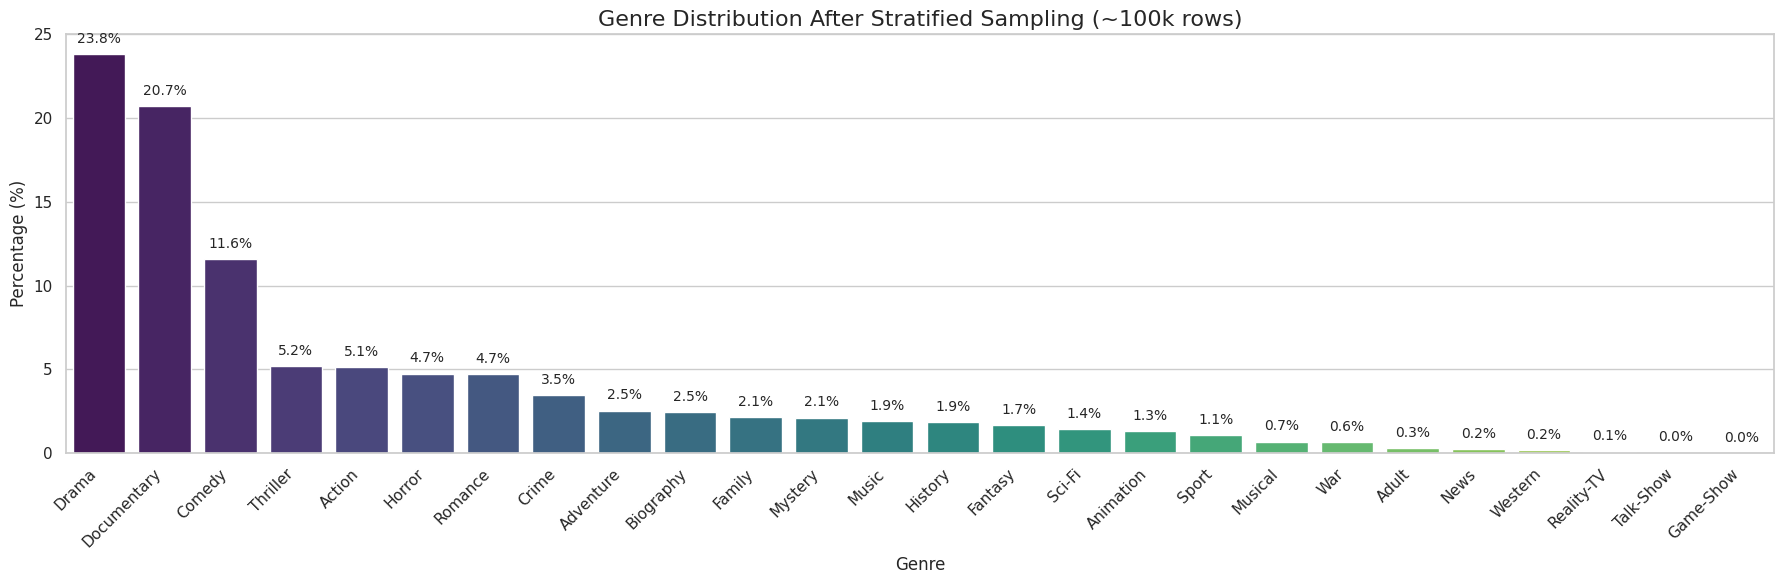

In [20]:
genre_counts_after = df_sampled['genre'].value_counts(normalize=True).reset_index()
genre_counts_after.columns = ['genre', 'percentage']
genre_counts_after['percentage'] *= 100
genre_counts_after = genre_counts_after.sort_values('percentage', ascending=False)

plt.figure(figsize=(18,6))
sns.barplot(x='genre', y='percentage', data=genre_counts_after, palette='viridis')
plt.title('Genre Distribution After Stratified Sampling (~100k rows)', fontsize=16)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')

for idx, row in enumerate(genre_counts_after.itertuples()):
    plt.text(idx, row.percentage + 0.5, f"{row.percentage:.1f}%", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [21]:
con.register("sampled_movies", df_sampled)

## Add Ratings to Sampled Movies

- Include only movies with valid `averageRating` and `numVotes`

In [22]:
con.execute("""
    CREATE TABLE sampled_ratings AS
    SELECT 
        s.tconst,
        s.startYear,
        s.genre,
        r.averageRating,
        r.numVotes
    FROM sampled_movies s
    JOIN read_csv_auto(
        '/kaggle/input/imdb-dataset/title.ratings.tsv',
        delim='\t',
        nullstr='\\N'
    ) r
    USING (tconst)
    WHERE r.averageRating IS NOT NULL
      AND r.numVotes IS NOT NULL
""")


In [23]:
avg_rating_per_genre = con.execute("""
    SELECT genre, AVG(averageRating) AS avg_rating
    FROM sampled_ratings
    GROUP BY genre
    ORDER BY avg_rating DESC
""").fetchdf()

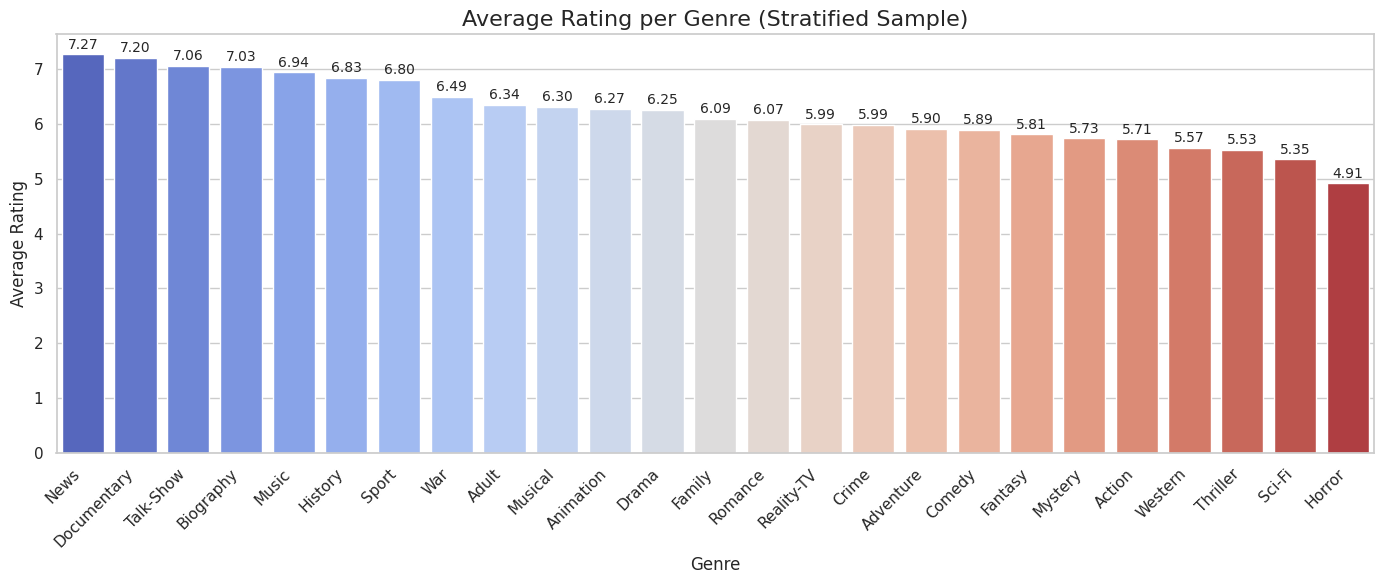

In [24]:
plt.figure(figsize=(14,6))
sns.barplot(x='genre', y='avg_rating', data=avg_rating_per_genre, palette='coolwarm')
plt.title('Average Rating per Genre (Stratified Sample)', fontsize=16)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.xticks(rotation=45, ha='right')

for idx, row in enumerate(avg_rating_per_genre.itertuples()):
    plt.text(idx, row.avg_rating + 0.05, f"{row.avg_rating:.2f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [25]:
genre_year_stats = con.execute("""
    CREATE OR REPLACE TABLE genre_year_stats AS
    SELECT
        genre,
        startYear,
        MEDIAN(averageRating) AS median_rating,
        MEDIAN(numVotes) AS median_votes,
        COUNT(*) AS movie_count
    FROM sampled_ratings
    GROUP BY genre, startYear
    ORDER BY genre, startYear
""")

In [26]:
genre_year_df = con.execute("SELECT * FROM genre_year_stats").fetchdf()

top_genres = (
    genre_year_df.groupby("genre")["movie_count"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
    .tolist()
)

genre_year_df_top = genre_year_df[genre_year_df["genre"].isin(top_genres)]
genre_year_df_top = genre_year_df_top.sort_values(["genre", "startYear"])

genre_year_df_top.head()

,genre,startYear,median_rating,median_votes,movie_count
0,Action,1995,5.50,157.5,82
1,Action,1996,5.50,238.0,74
2,Action,1997,5.70,263.0,63
3,Action,1998,5.40,147.0,64
4,Action,1999,5.75,125.5,58


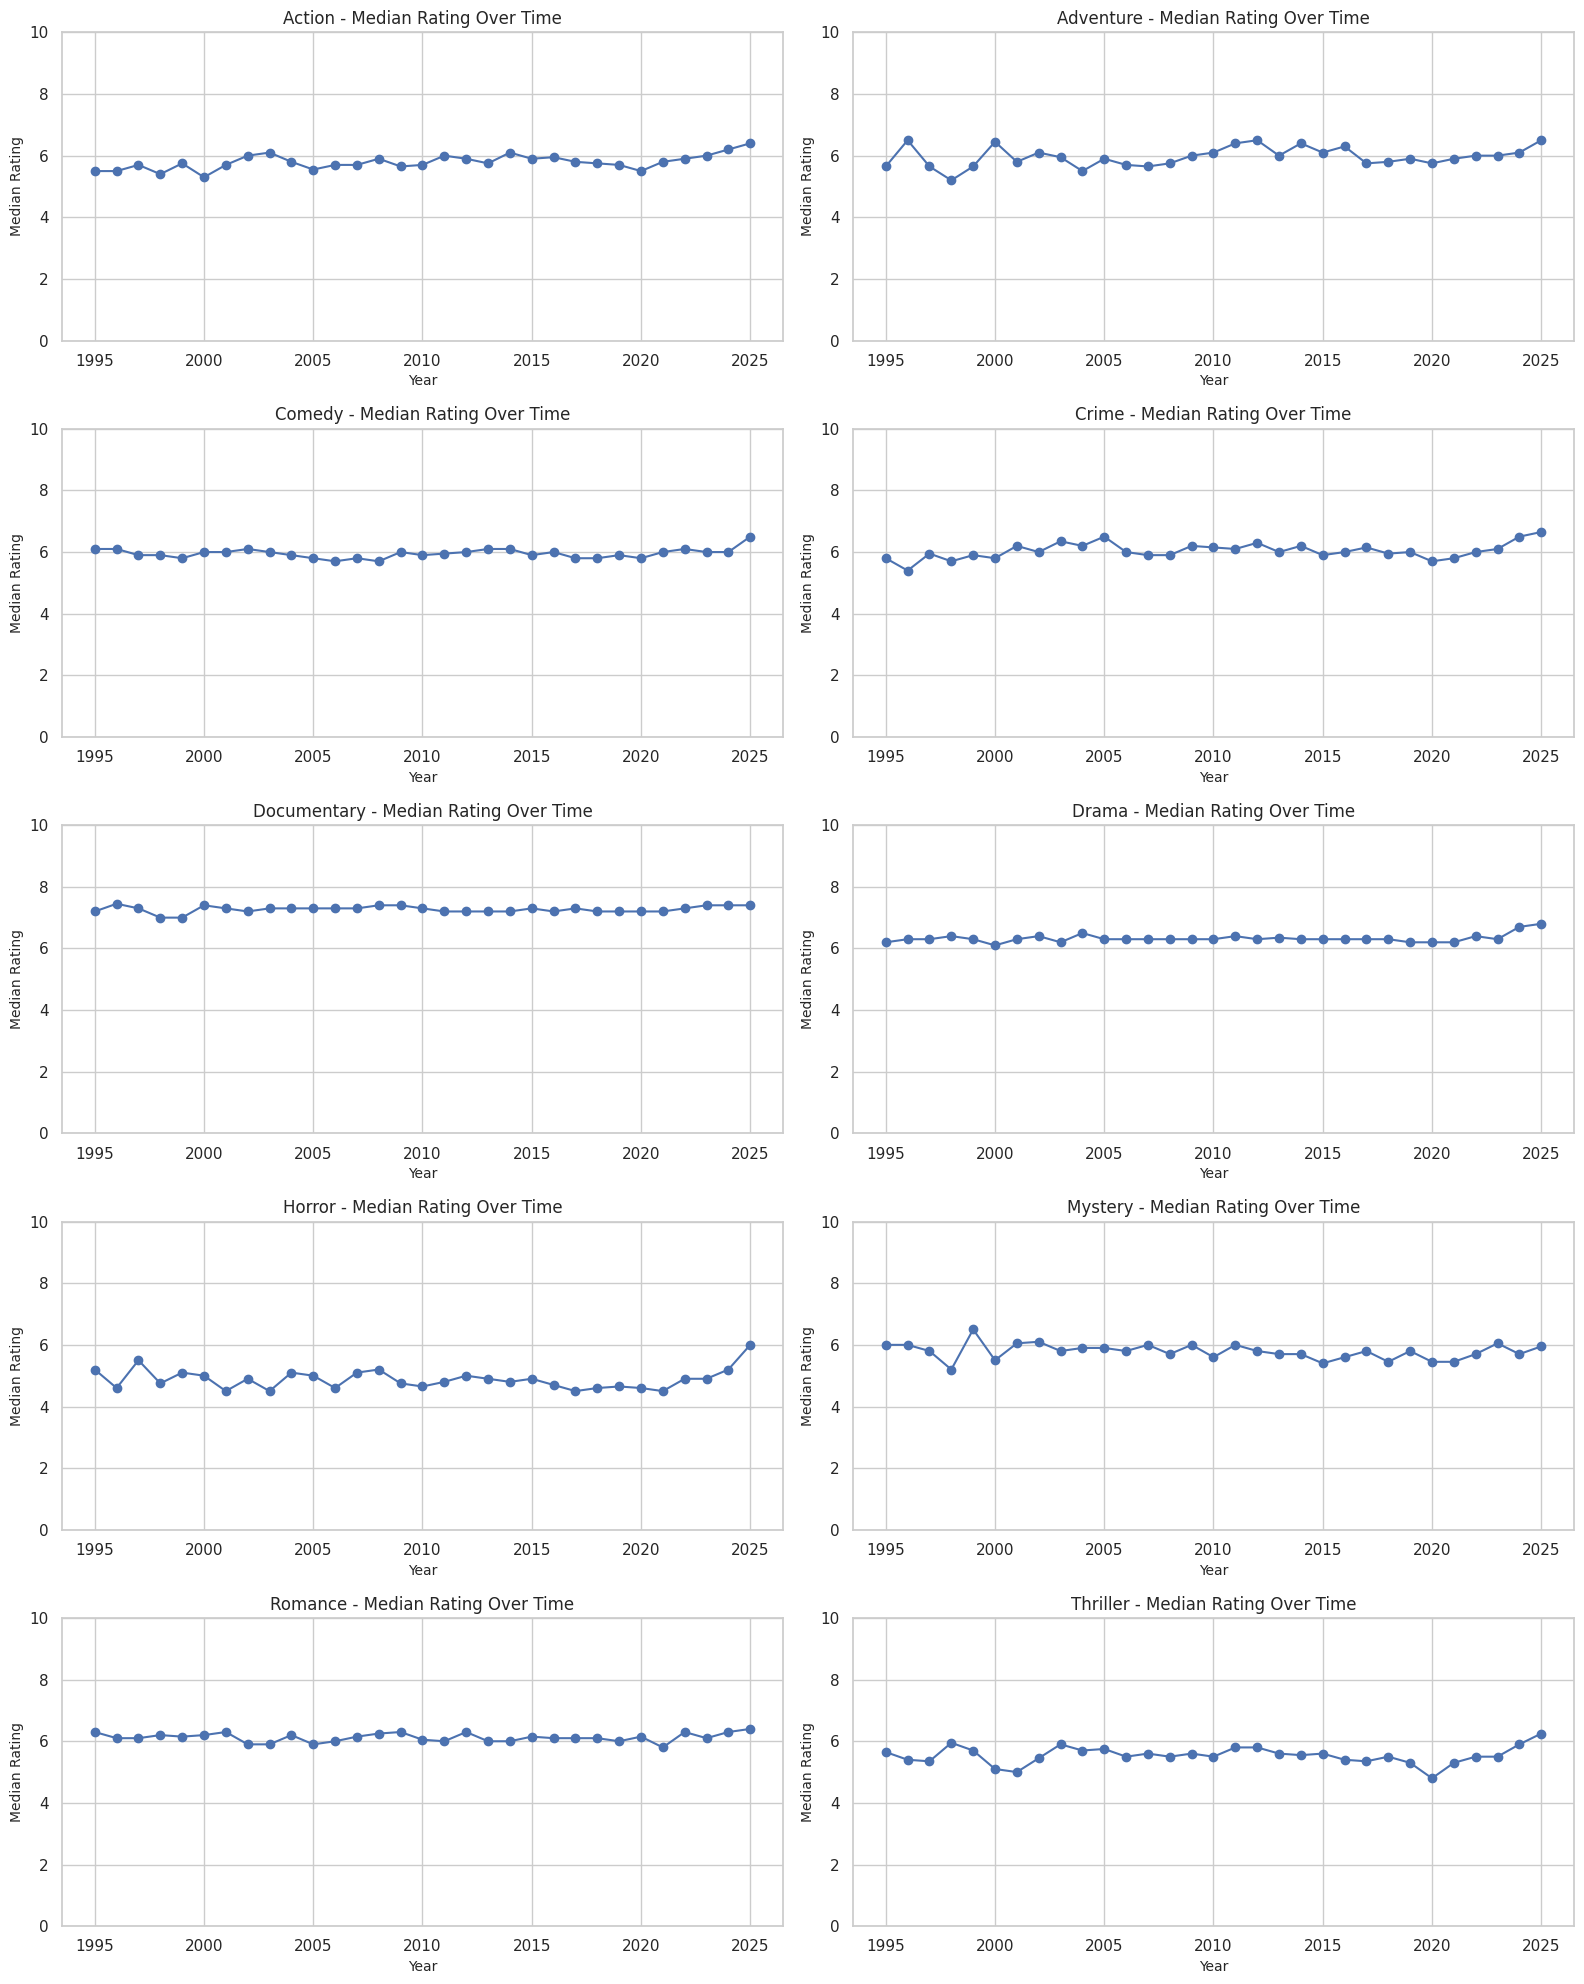

In [27]:
plt.figure(figsize=(16, 20))

genres = genre_year_df_top['genre'].unique()
num_genres = len(genres)

for i, genre in enumerate(genres, 1):
    plt.subplot(5, 2, i)
    data = genre_year_df_top[genre_year_df_top['genre'] == genre]
    plt.plot(data['startYear'], data['median_rating'], marker='o')
    plt.title(f"{genre} - Median Rating Over Time", fontsize=12)
    plt.xlabel("Year", fontsize=10)
    plt.ylabel("Median Rating", fontsize=10)
    plt.ylim(0, 10)

plt.tight_layout()
plt.show()

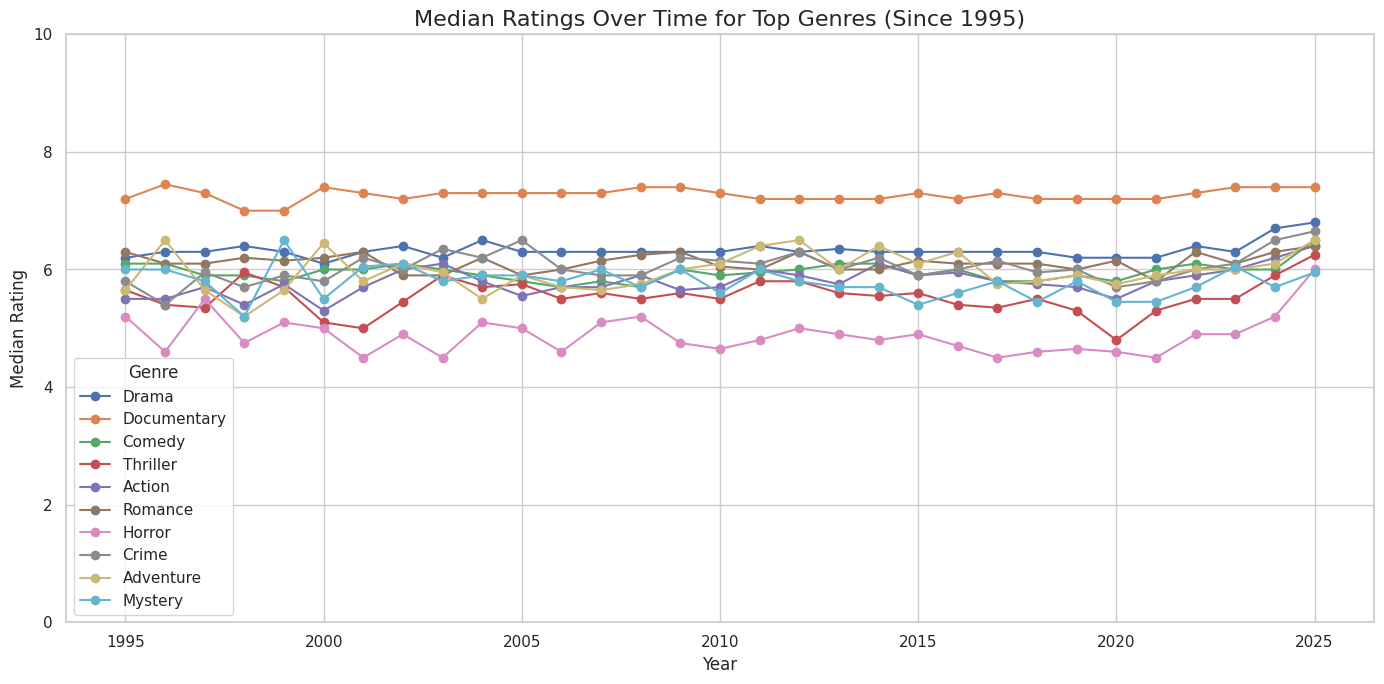

In [33]:
plt.figure(figsize=(14, 7))

for genre in top_genres:
    data = genre_year_df_top[genre_year_df_top['genre'] == genre]
    plt.plot(data['startYear'], data['median_rating'], marker='o', label=genre)

plt.title('Median Ratings Over Time for Top Genres (Since 1995)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Median Rating', fontsize=12)
plt.ylim(0, 10)
plt.legend(title='Genre')
plt.grid(True)
plt.tight_layout()
plt.show()

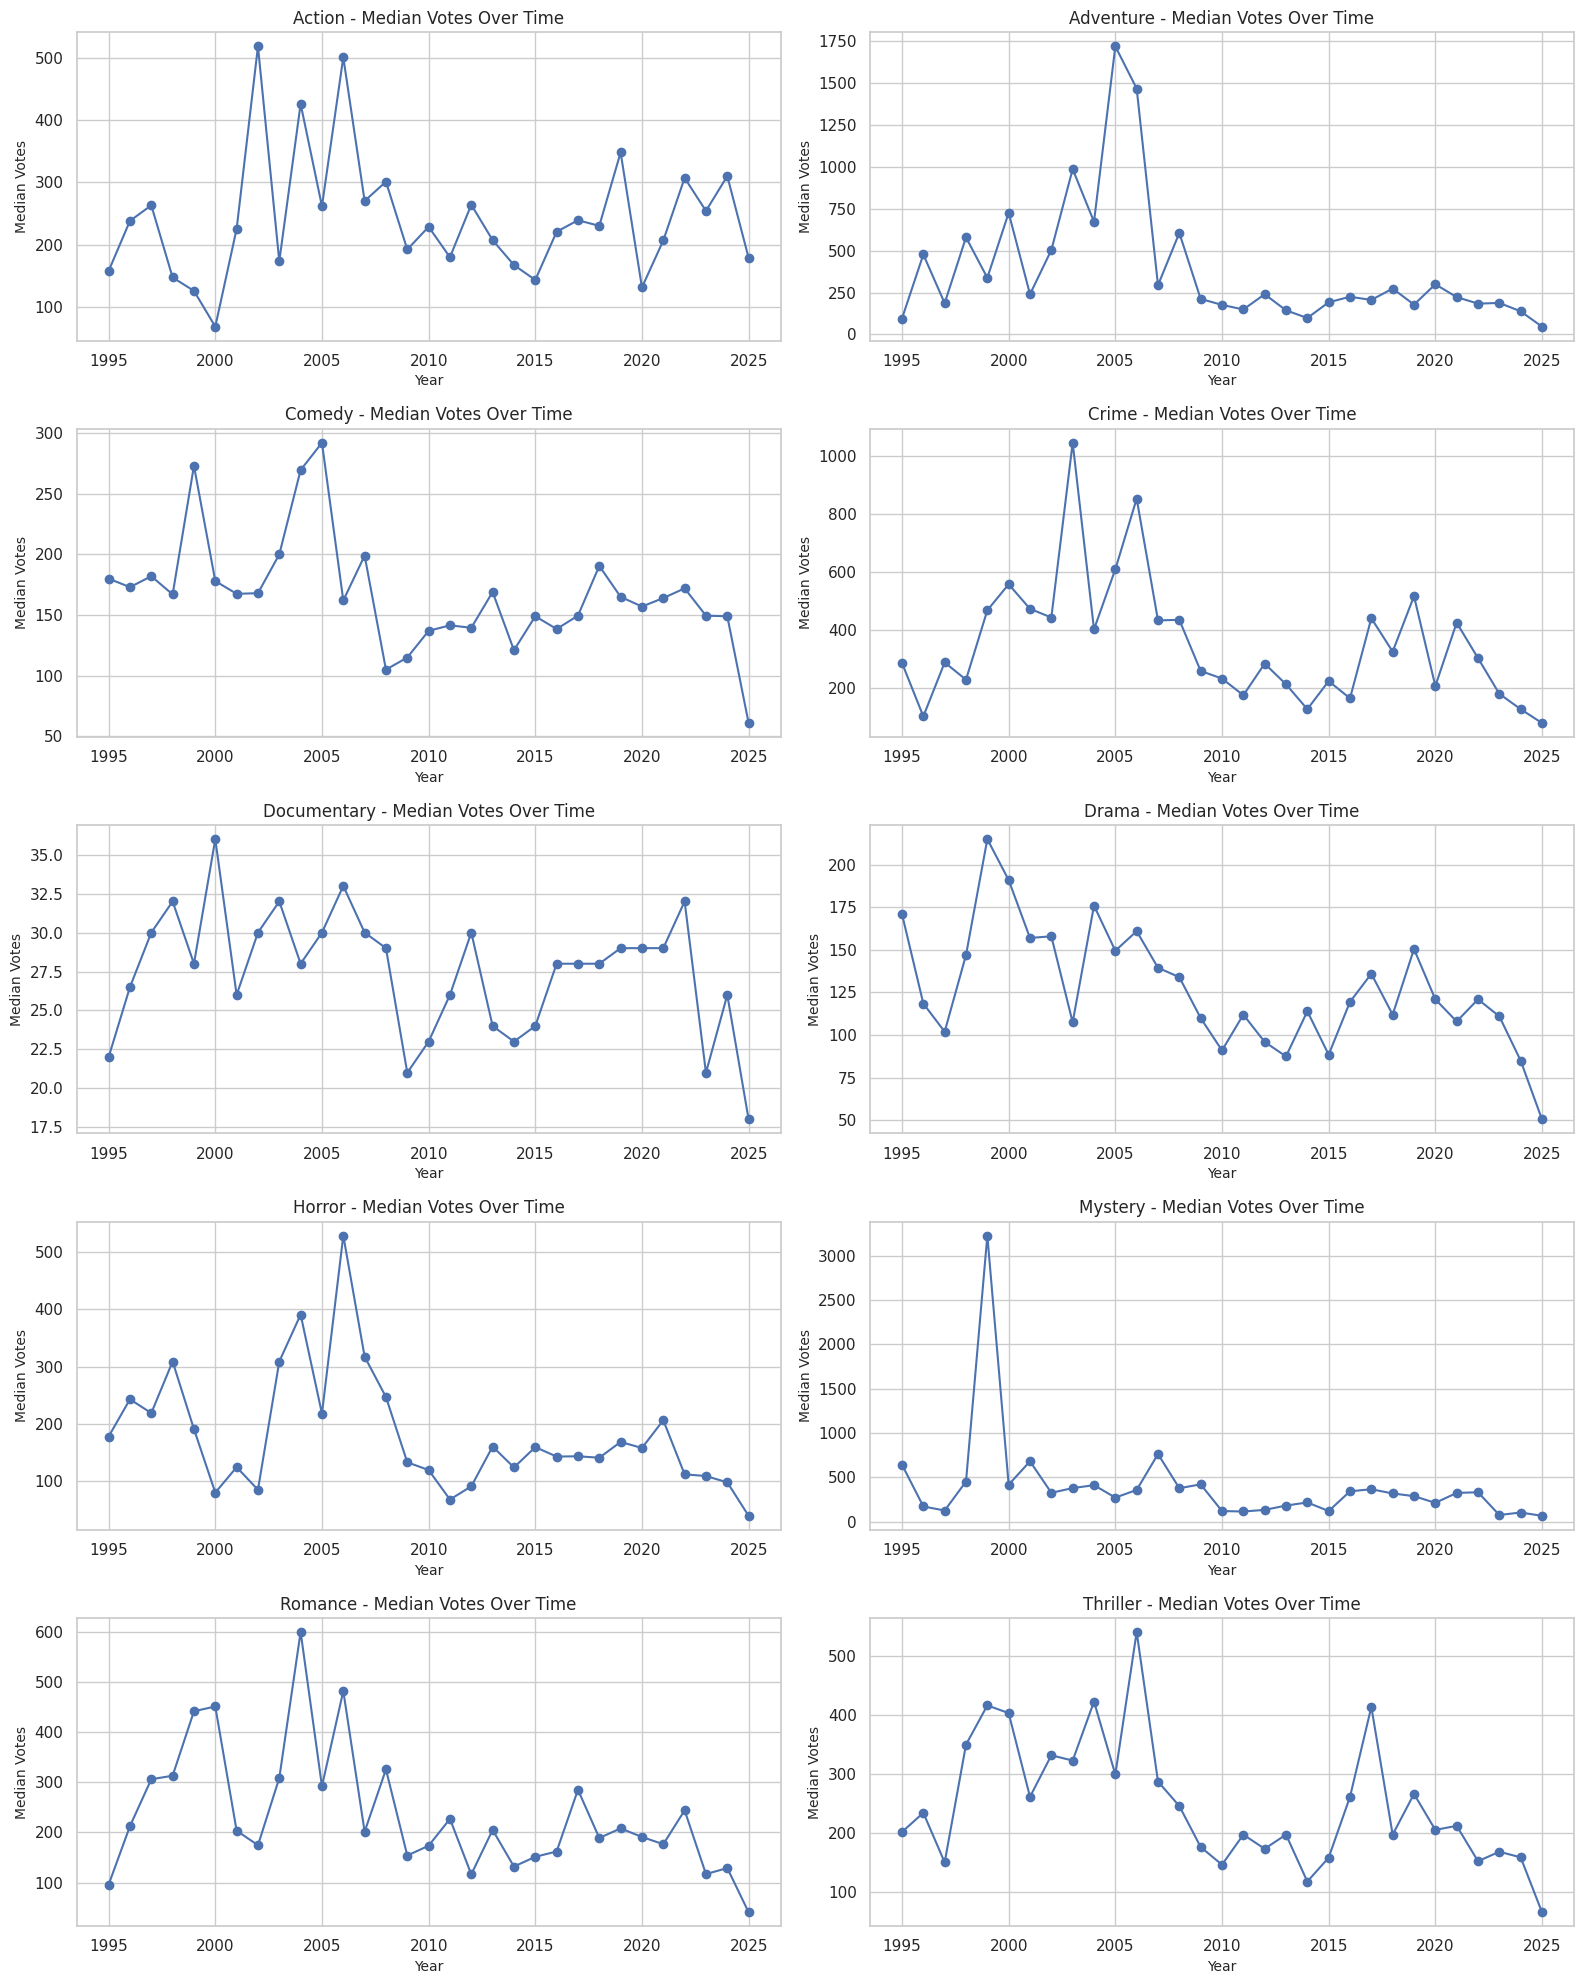

In [28]:
plt.figure(figsize=(16, 20))

for i, genre in enumerate(genres, 1):
    plt.subplot(5, 2, i)
    data = genre_year_df_top[genre_year_df_top['genre'] == genre]
    plt.plot(data['startYear'], data['median_votes'], marker='o')
    plt.title(f"{genre} - Median Votes Over Time", fontsize=12)
    plt.xlabel("Year", fontsize=10)
    plt.ylabel("Median Votes", fontsize=10)

plt.tight_layout()
plt.show()

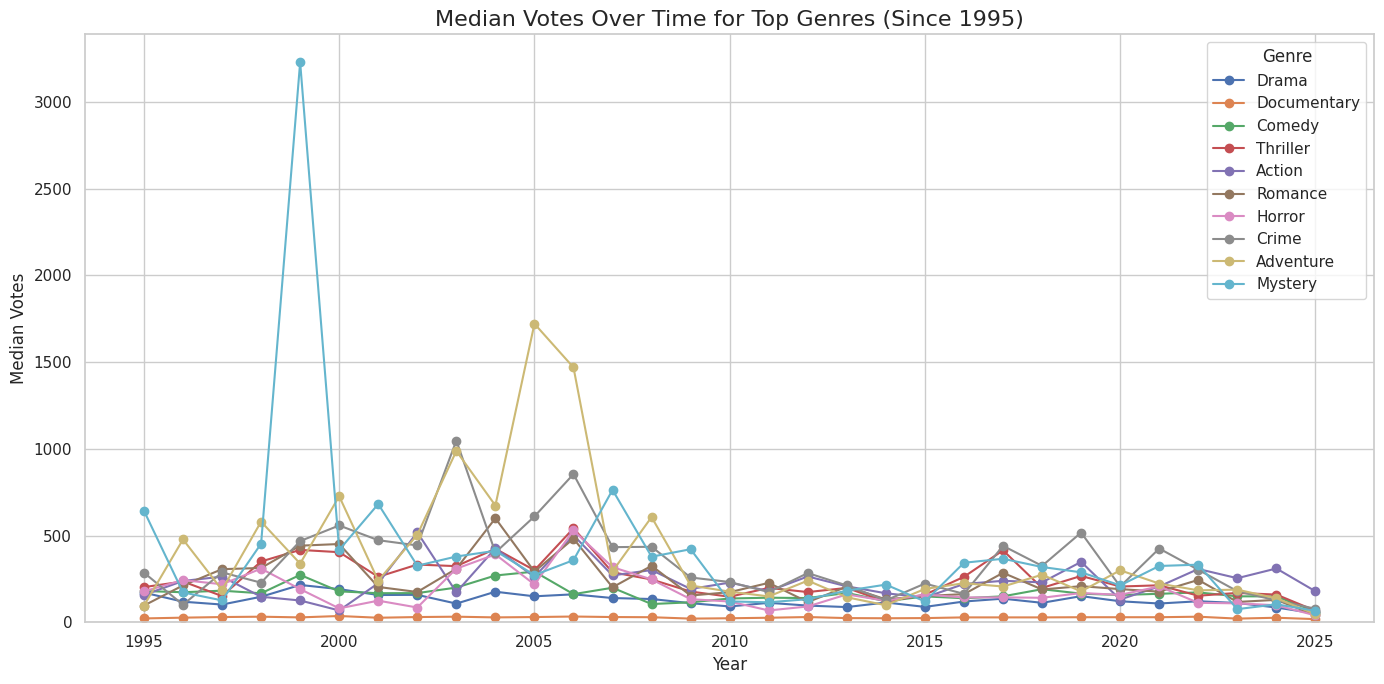

In [34]:
plt.figure(figsize=(14, 7))

for genre in top_genres:
    data = genre_year_df_top[genre_year_df_top['genre'] == genre]
    plt.plot(data['startYear'], data['median_votes'], marker='o', label=genre)

plt.title('Median Votes Over Time for Top Genres (Since 1995)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Median Votes', fontsize=12)
plt.ylim(0)  # start y-axis at 0
plt.legend(title='Genre')
plt.grid(True)
plt.tight_layout()
plt.show()

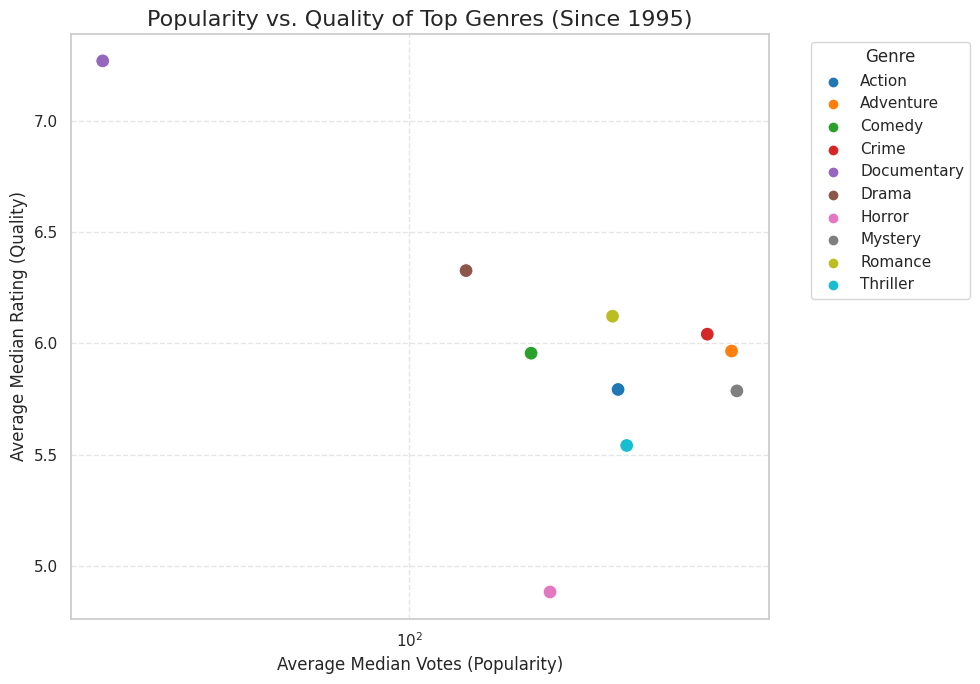

In [35]:
# Aggregate per genre across all years
genre_summary = genre_year_df_top.groupby('genre').agg(
    avg_median_rating=('median_rating', 'mean'),
    avg_median_votes=('median_votes', 'mean')
).reset_index()

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='avg_median_votes',
    y='avg_median_rating',
    data=genre_summary,
    hue='genre',
    s=100,
    palette='tab10'
)

plt.title('Popularity vs. Quality of Top Genres (Since 1995)', fontsize=16)
plt.xlabel('Average Median Votes (Popularity)', fontsize=12)
plt.ylabel('Average Median Rating (Quality)', fontsize=12)
plt.xscale('log')  # use log scale for votes to make differences clearer
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [29]:
top_genres_stats = genre_year_df_top.groupby('genre').agg(
    avg_median_rating=('median_rating', 'mean'),
    avg_median_votes=('median_votes', 'mean'),
    total_movies=('movie_count', 'sum')
).sort_values('total_movies', ascending=False).reset_index()

top_genres_stats

,genre,avg_median_rating,avg_median_votes,total_movies
0,Drama,6.327419,127.112903,16136
1,Documentary,7.269355,27.467742,8803
2,Comedy,5.956452,167.225806,8749
3,Thriller,5.541935,250.241935,3983
4,Action,5.793548,241.306452,3767
5,Romance,6.122581,235.774194,3703
6,Horror,4.883871,181.145161,3598
7,Crime,6.041935,351.516129,2754
8,Adventure,5.966129,389.419355,1843
9,Mystery,5.787097,398.290323,1628


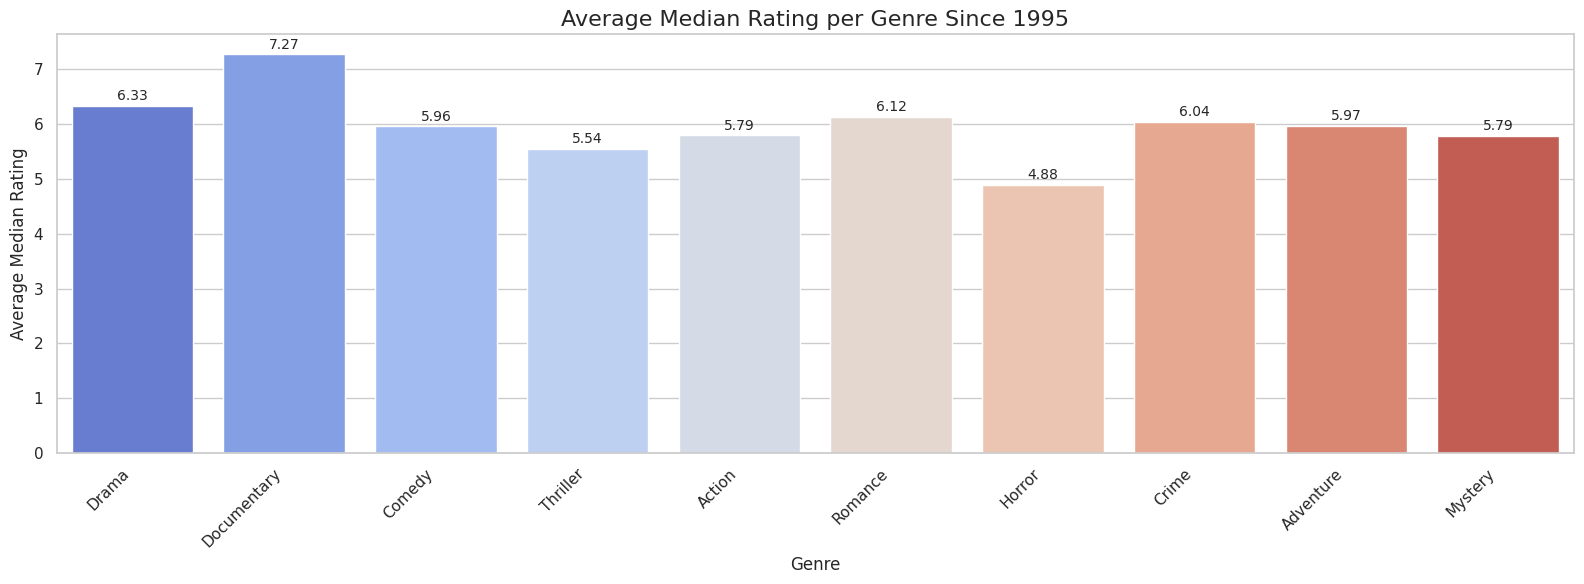

In [31]:
plt.figure(figsize=(16,6))
sns.barplot(
    x='genre',
    y='avg_median_rating',
    data=top_genres_stats,
    palette='coolwarm'
)
plt.title('Average Median Rating per Genre Since 1995', fontsize=16)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Average Median Rating', fontsize=12)
plt.xticks(rotation=45, ha='right')

for i, row in enumerate(top_genres_stats.itertuples()):
    plt.text(i, row.avg_median_rating + 0.05, f"{row.avg_median_rating:.2f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

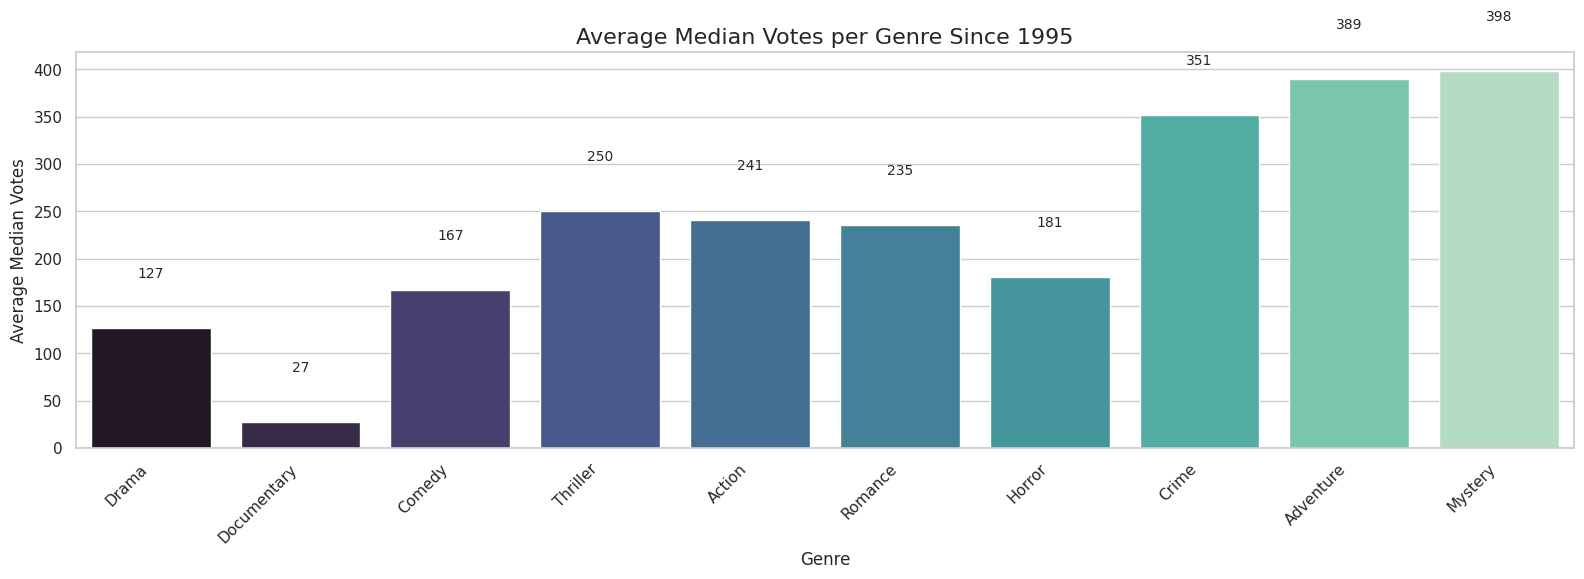

In [32]:
plt.figure(figsize=(16,6))
sns.barplot(
    x='genre',
    y='avg_median_votes',
    data=top_genres_stats,
    palette='mako'
)
plt.title('Average Median Votes per Genre Since 1995', fontsize=16)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Average Median Votes', fontsize=12)
plt.xticks(rotation=45, ha='right')

for i, row in enumerate(top_genres_stats.itertuples()):
    plt.text(i, row.avg_median_votes + 50, f"{int(row.avg_median_votes)}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Key Insights (Since 1995)

- **Quality Stable:**  
  Median ratings for most genres have been very stable over the last 30 years.

- **Popularity Declining:**  
  Audience engagement (median votes) is generally lower and more volatile compared to peaks in the early 2000s.

- **Documentaries – Quality King:**  
  Documentaries have the highest median quality (~7.27) but are the least popular (lowest votes).

- **Popular Genres = Moderate Quality:**  
  The most popular genres (Mystery, Adventure, Crime) have moderate quality ratings (~6.0).

- **Horror – Niche Appeal:**  
  Horror is the lowest-rated genre (~4.88) yet maintains moderate audience interest.

- **Drama Prevalence:**  
  Drama is the most produced genre, making up nearly a quarter of all titles (23.8%).